<a href="https://colab.research.google.com/github/Meraz2837/Ethnic-Group-Classification-Using-Custom-CNN/blob/main/ethnic_group_classification_using_custom_cnn_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [8]:
BATCH_SIZE = 32
IMAGE_SIZE = 224
CHANNELS=3
EPOCHS=50

In [9]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Research Assistant/Custom Model/Dataset",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 3001 files belonging to 3 classes.


In [10]:
class_names = dataset.class_names
class_names

['East Asian', 'Indian', 'Southeast Asian']

In [11]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 224, 224, 3)
[1 0 0 1 0 0 1 2 1 0 2 1 0 1 0 2 0 0 0 2 0 2 0 0 2 1 0 2 0 2 1 2]


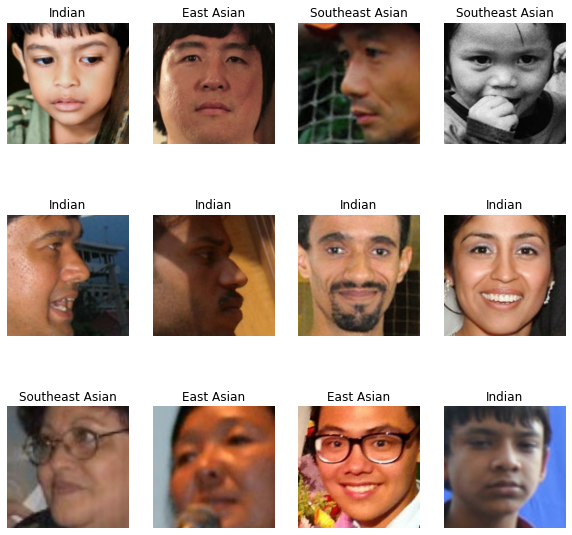

In [12]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [13]:
len(dataset)

94

In [14]:
train_size = 0.8
len(dataset)*train_size

75.2

In [15]:
train_ds = dataset.take(75)
len(train_ds)

75

In [17]:
test_ds = dataset.skip(75)
len(test_ds)

19

In [18]:
val_size=0.1
len(dataset)*val_size

9.4

In [19]:
val_ds = test_ds.take(9)
len(val_ds)

9

In [20]:
test_ds = test_ds.skip(9)
len(test_ds)

10

In [21]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [22]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [23]:
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

75
9
10


In [24]:
len(dataset)

94

In [25]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [26]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [27]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [28]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [29]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [30]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 224, 224, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 222, 222, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 111, 111, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 109, 109, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 54, 54, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 52, 52, 64)         

In [31]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [33]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
75/75 [==============================] - 203s 3s/step - loss: 1.0613 - accuracy: 0.4229 - val_loss: 1.0705 - val_accuracy: 0.3924
Epoch 2/50
75/75 [==============================] - 202s 3s/step - loss: 1.0638 - accuracy: 0.4242 - val_loss: 1.0652 - val_accuracy: 0.4201
Epoch 3/50
75/75 [==============================] - 202s 3s/step - loss: 1.0583 - accuracy: 0.4350 - val_loss: 1.0586 - val_accuracy: 0.4236
Epoch 4/50
75/75 [==============================] - 203s 3s/step - loss: 1.0503 - accuracy: 0.4388 - val_loss: 1.0492 - val_accuracy: 0.4653
Epoch 5/50
75/75 [==============================] - 207s 3s/step - loss: 1.0462 - accuracy: 0.4450 - val_loss: 1.0601 - val_accuracy: 0.4410
Epoch 6/50
75/75 [==============================] - 207s 3s/step - loss: 1.0371 - accuracy: 0.4476 - val_loss: 1.0460 - val_accuracy: 0.4444
Epoch 7/50
75/75 [==============================] - 204s 3s/step - loss: 1.0360 - accuracy: 0.4421 - val_loss: 1.0347 - val_accuracy: 0.4444
Epoch 8/50
75

In [34]:
scores = model.evaluate(test_ds)

10/10 [==============================] - 14s 650ms/step - loss: 0.7954 - accuracy: 0.6313


In [35]:
scores

[0.7954131364822388, 0.6312500238418579]

In [36]:
history.params

{'epochs': 50, 'steps': 75, 'verbose': 1}

In [37]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

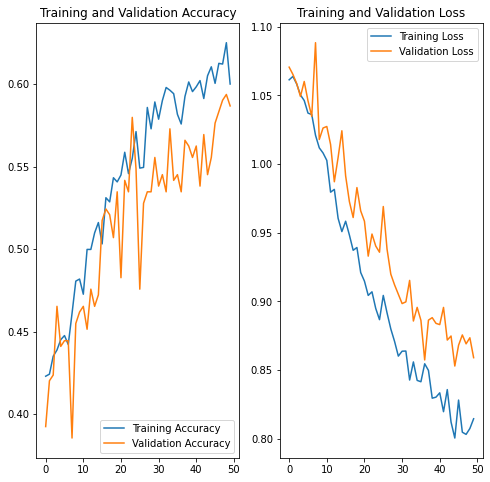

In [39]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: East Asian
predicted label: East Asian


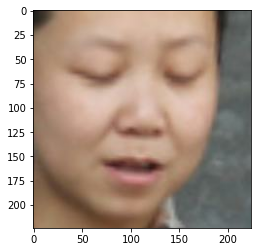

In [40]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [41]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

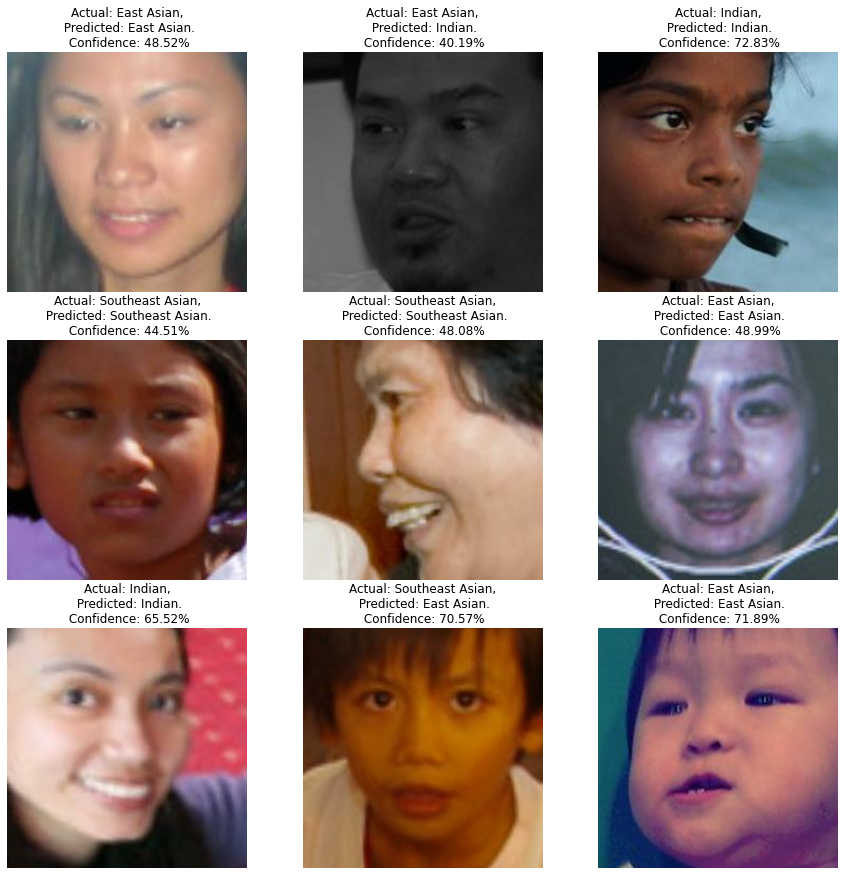

In [42]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")